In [3]:
MICRO_SEG_NET_PATH = '/ssd005/projects/exactvu_pca/micro_seg_net_data'
TARGET_DIR = '/ssd005/projects/exactvu_pca/micro_seg_net_data_png'

In [4]:
from pathlib import Path 
import SimpleITK as sitk

target_dir = Path(TARGET_DIR)
source_dir = Path(MICRO_SEG_NET_PATH)

target_dir.joinpath('train').mkdir(exist_ok=True)
target_dir.joinpath('test').mkdir(exist_ok=True)

list(source_dir.iterdir())

[PosixPath('/ssd005/projects/exactvu_pca/micro_seg_net_data/train'),
 PosixPath('/ssd005/projects/exactvu_pca/micro_seg_net_data/.DS_Store'),
 PosixPath('/ssd005/projects/exactvu_pca/micro_seg_net_data/test')]

In [14]:
from pathlib import Path 
import SimpleITK as sitk
from typing import Literal
from torch.utils.data import Dataset
from PIL import Image
import re

from tqdm import tqdm

class MicroSegNetDataset(Dataset):
    def __init__(
        self,
        root: Path | str,
        transform=None,
        target_transform=None,
        split: Literal["train", "test"] = "train",
        preprocess=None,
        raw_data_dir: Path | str | None = None,
    ): 
        self.root = root if isinstance(root, Path) else Path(root)
        self.transform = transform 
        self.target_transform = target_transform
        self.split = split 

        self._image_folder = (self.root / self.split / 'micro_ultrasound_scans')
        self._mask_folder = (self.root / self.split / 'expert_annotations')

        self._image_paths = sorted(self._image_folder.iterdir(), key=self._extract_indices)
        self._mask_paths = sorted(self._mask_folder.iterdir(), key=self._extract_indices)

        if len(self._image_paths) == 0 or preprocess: 
            # should try to preprocess the data
            assert raw_data_dir is not None, 'Raw data directory must be provided'
            raw_data_dir = raw_data_dir if isinstance(raw_data_dir, Path) else Path(raw_data_dir)
            self._preprocess_data(self.root, raw_data_dir)
        
    def __len__(self): 
        return len(self._image_paths)

    def __getitem__(self, index):
        image_path = self._image_paths[index]
        mask_path = self._mask_paths[index]
        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return image, mask

    def _extract_indices(self, path: Path):
        return list(map(int, re.search('(\d+)', path.name).groups()))

    def _preprocess_data(self, target_dir: Path, source_dir: Path): 
        target_dir.joinpath('train').mkdir(exist_ok=True)
        target_dir.joinpath('test').mkdir(exist_ok=True)
        for split in ['train', 'test']:
            scans_dir = source_dir.joinpath(split).joinpath('micro_ultrasound_scans')
            annotations_dir = source_dir.joinpath(split).joinpath('expert_annotations')
            target_scans_dir = target_dir.joinpath(split).joinpath('micro_ultrasound_scans')
            target_annotations_dir = target_dir.joinpath(split).joinpath('expert_annotations')
            target_scans_dir.mkdir(exist_ok=True)
            target_annotations_dir.mkdir(exist_ok=True)

            def _read_id_from_path(path): 
                id = int(re.search('(\d+)', str(path.name)).groups()[0])
                return id 
                
            scans_paths = sorted(scans_dir.iterdir(), key=_read_id_from_path)
            annotations_paths = sorted(annotations_dir.iterdir(), key=_read_id_from_path)

            for id, (scan, target) in enumerate(tqdm(zip(scans_paths, annotations_paths), desc=f'Preprocessing {split} data', total=len(scans_paths))): 
                scan = sitk.GetArrayFromImage(sitk.ReadImage(scan)).astype('uint8')
                annotation = sitk.GetArrayFromImage(sitk.ReadImage(target)).astype('uint8')

                for frame_idx, (frame, target_frame) in enumerate(zip(scan, annotation)): 
                    scan_output_path = (target_scans_dir / f'{id}_{frame_idx}.png')
                    annotations_path = (target_annotations_dir / f'{id}_{frame_idx}.png')
                    frame = Image.fromarray(frame)
                    target_frame = Image.fromarray(target_frame)
                    frame.save(scan_output_path)
                    target_frame.save(annotations_path)

        
MicroSegNetDataset(TARGET_DIR, split='train', raw_data_dir=MICRO_SEG_NET_PATH, preprocess=True)

Preprocessing test data: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


1925

In [56]:
import re
import cv2
from PIL import Image 

for split in ['train', 'test']:

    scans_dir = source_dir.joinpath(split).joinpath('micro_ultrasound_scans')
    annotations_dir = source_dir.joinpath(split).joinpath('expert_annotations')
    target_scans_dir = target_dir.joinpath(split).joinpath('micro_ultrasound_scans')
    target_annotations_dir = target_dir.joinpath(split).joinpath('expert_annotations')
    target_scans_dir.mkdir(exist_ok=True)
    target_annotations_dir.mkdir(exist_ok=True)

    def _read_id_from_path(path): 
        id = int(re.search('(\d+)', str(path.name)).groups()[0])
        return id 
        
    scans_paths = sorted(scans_dir.iterdir(), key=_read_id_from_path)
    annotations_paths = sorted(annotations_dir.iterdir(), key=_read_id_from_path)

    for id, (scan, target) in enumerate(zip(scans_paths, annotations_paths)): 
        scan = sitk.GetArrayFromImage(sitk.ReadImage(scan)).astype('uint8')
        annotation = sitk.GetArrayFromImage(sitk.ReadImage(target)).astype('uint8')

        for frame_idx, (frame, target_frame) in enumerate(zip(scan, annotation)): 
            scan_output_path = (target_scans_dir / f'{id}_{frame_idx}.png')
            annotations_path = (target_annotations_dir / f'{id}_{frame_idx}.png')
            frame = Image.fromarray(frame)
            target_frame = Image.fromarray(target_frame)
            frame.save(scan_output_path)
            target_frame.save(annotations_path)

    scan.shape
    scan.min()


0

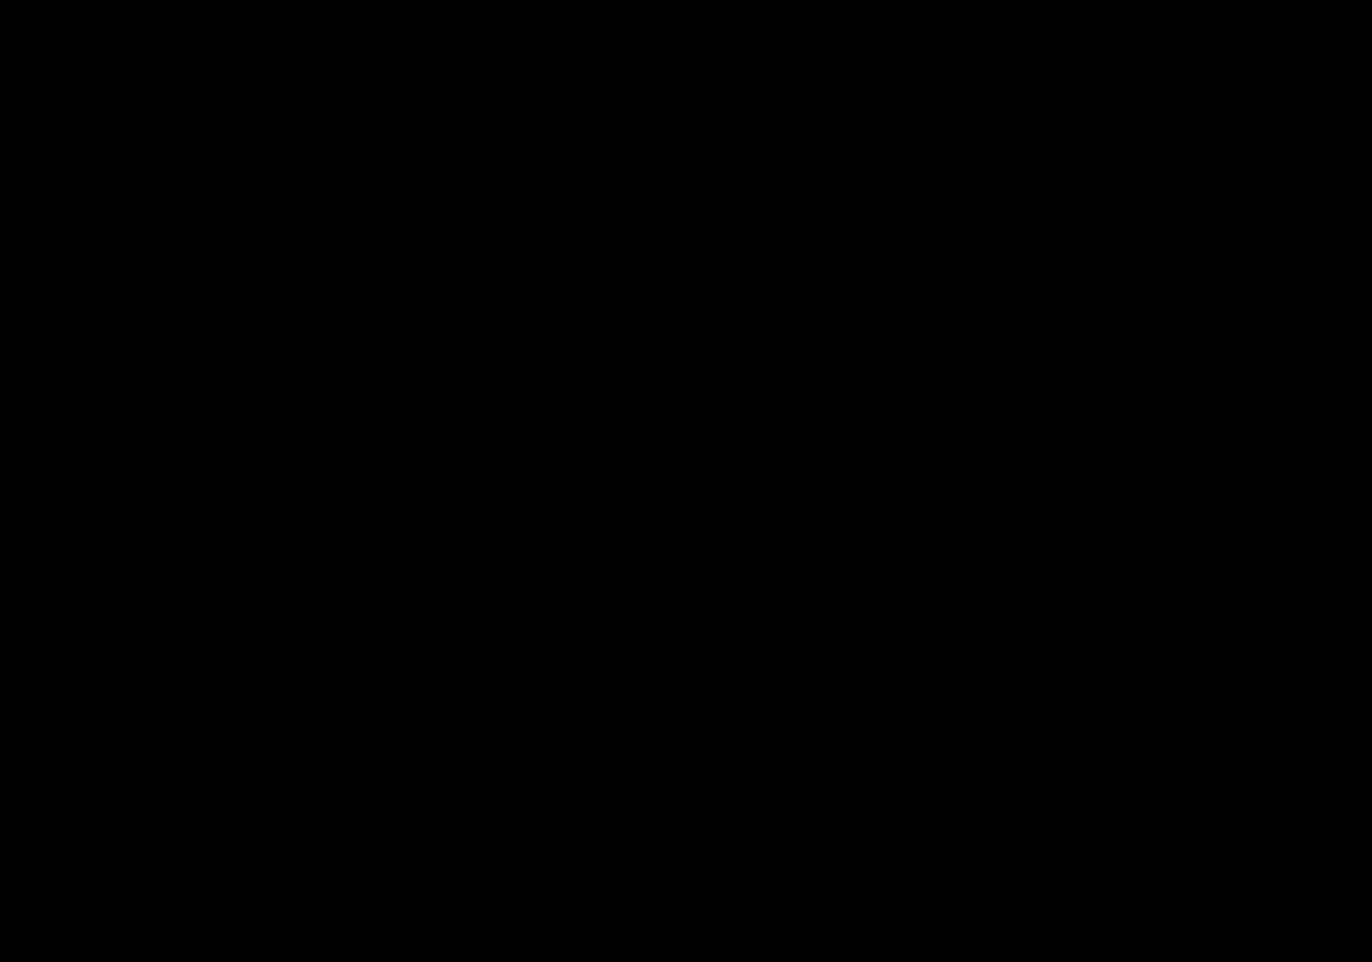

In [60]:
Image.open('/ssd005/projects/exactvu_pca/micro_seg_net_data_png/train/expert_annotations/0_20.png')

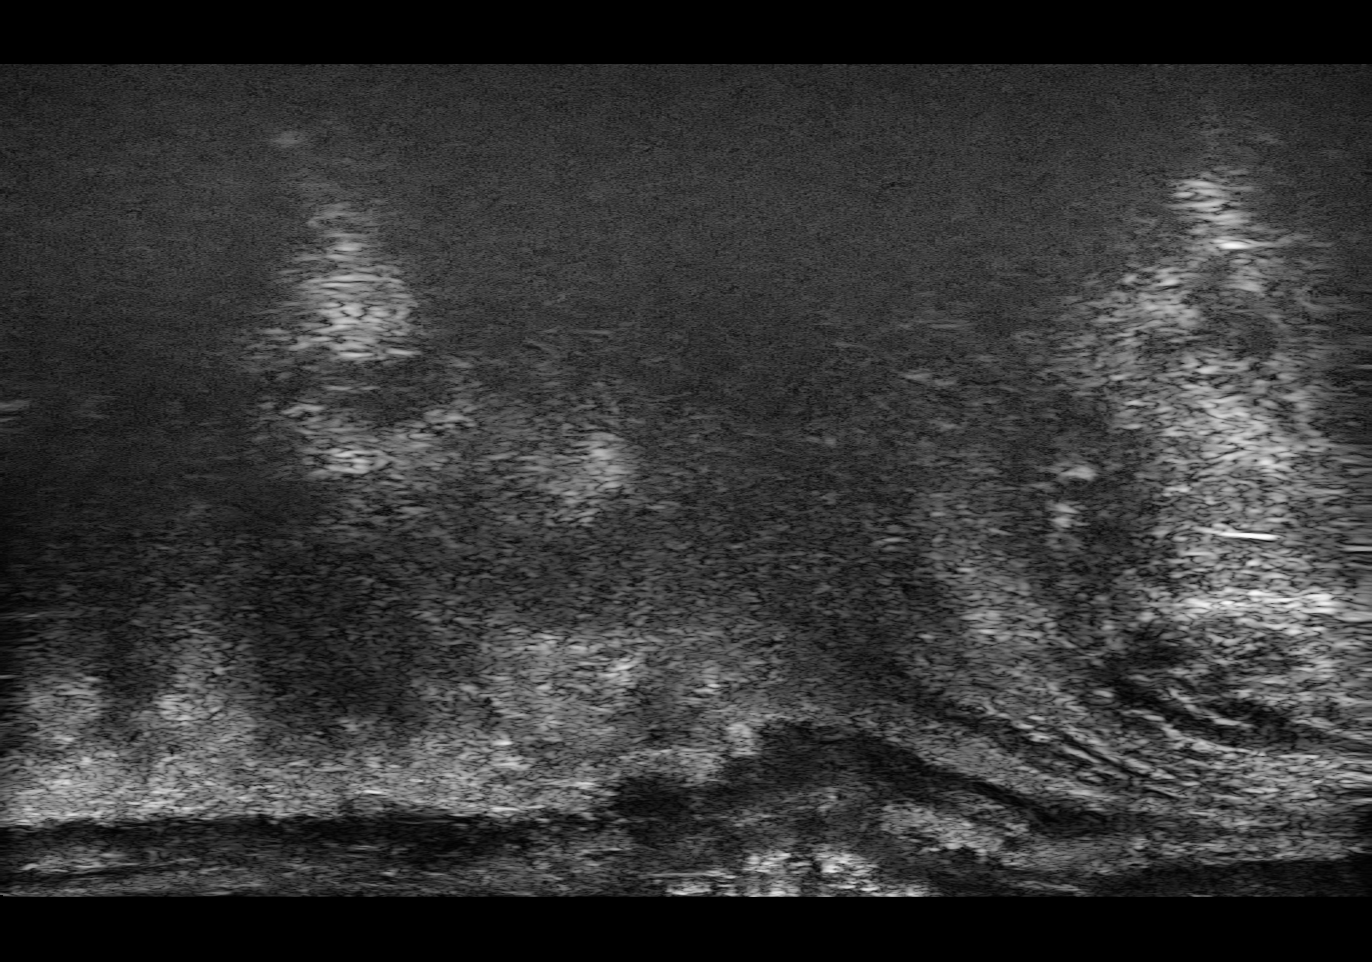

In [55]:
from PIL import Image 
annotation.shape

Image.fromarray(frame)

In [48]:
annotation.min()
annotation.max()

1

In [44]:
scan.shape
scan.max()

254

In [42]:
scan.shape

(45, 962, 1372)

In [16]:
%cd ..
from src.ssl_evaluation import build_linear_probe_for_nct_patches

probe = build_linear_probe_for_nct_patches()

/fs01/home/pwilson/projects/ibot


In [20]:
probe.train_loader.dataset[0][0].shape

torch.Size([3, 512, 512])